<a href="https://colab.research.google.com/github/RGologorsky/fastmri/blob/master/01_kspace_learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Better to learn in kspace or image space?

## Overview

Study based on "Transfusion: Understanding Transfer Learning for Medical Imaging"

- Small architechtures perform comparably to large ones for medical tasks
- Perf on ImageNet pretraining is not indicative of perf on final medical task

Compare:

1. Task domain: learn in kspace vs learn in image space
2. Param init: w/ and wo/ transfer learning/pretraining 
3. Architcture: small vs. large  arch

First experiment: task domain
- Train a small model from scratch: **learn in kspace**
- Train a small model from scratch: learn in image space

### Setup

In [0]:
PROJ       = "fastmri"

In [2]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
from pathlib import Path 

ROOT = "/content/drive"     # default location for the drive
drive.mount(ROOT)           # mount google drive at /content/drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ALL_PROJ_PATH = Path(ROOT)/"My Drive/fastai_proj/"  # path to all projects 
PROJ_PATH   = ALL_PROJ_PATH/PROJ                    # path to project on PROJ
PROJ_PATH.mkdir(parents=True, exist_ok=True)        # make dir in PROJ to house Github

In [4]:
%run "$PROJ_PATH/common_constants_env.ipynb" # pip install fastai, fastmri, etc

pip install fastai2
git clone fastMRI
pip install ISMRMRD
pip install fasMRI req
sys append /content/fastMRI
imports


## Data

## MRI data

In [0]:
import json

In [0]:
ds_name = "knee_singlecoil_val" # dataset name
DS2DIR = {"knee_singlecoil_val": "singlecoil_val"}

In [13]:
path_json = PROJ_PATH/"data"/DS2DIR[ds_name]/"fn2attr.json"
path_json

Path('/content/drive/My Drive/fastai_proj/fastmri/data/singlecoil_val/fn2attr.json')

In [14]:
%time fn2attr = json.load(path_json)

CPU times: user 620 µs, sys: 106 µs, total: 726 µs
Wall time: 1.6 s


## Imagenette data

In [162]:
path_net = untar_data(URLs.IMAGENETTE_160)
fnames_net = get_image_files(path_net)

In [164]:
fn_net_test = fnames_net[0]
fn_net_test

Path('/root/.fastai/data/imagenette2-160/val/n03394916/n03394916_36911.JPEG')

# Viz kspace

In [0]:
# apparently scipy fft interleaves Real+Im of single px as 2 adj vals 
# https://stackoverflow.com/questions/38476359/fft-on-image-with-python/38507628
import scipy.fft as fp

In [0]:
fn2bw = Pipeline([PILImageBW.create])

# ck = centered kspace, is = image space
fn2ck = Pipeline([PILImageBW.create, np.array, fp.rfft2, np.fft.fftshift])
ck2im  = Pipeline([np.fft.ifftshift, fp.irfft2, PILImageBW.create])

# showing amplitude (not phase)
k2amp   = Pipeline([add(1e-9), np.log, np.abs])
#amp2im = Pipeline([fp.irfft2, np.fft.ifftshift])

# expects batch of kslices. T.ifft includes shifting
xb2im = Pipeline([T.to_tensor, T.ifft2, T.complex_abs])

# makes a k slice into a batch, applied xb2im
def ks2im(kslice): return xb2im(kslice[None,:])[0]

## test

In [0]:
def idx(lst,i, default=None): return lst[i] if i < len(lst) else default
def rep(o,n): return [o for _ in range(n)]

In [0]:
# useful fn to plot image fns in *args

def plot(imgs, titles, cmaps, nrows=1, ncols=1, figsize = (6,6), **kwargs):
  fig,axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
  axes = axes.flatten()
  for i,im in enumerate(imgs): 
    axes[i].imshow(im, cmap=idx(cmaps,i))
    axes[i].set_xticklabels([]), axes[i].set_yticklabels([])
    axes[i].set_title(idx(titles,i))
  fig.show()

In [0]:
im_test = fn2bw(fn_net_test)
ck_test  = fn2ck(fn_net_test)
amp_test = k2amp(ck_test)
im_rev   = ck2im(ck_test)

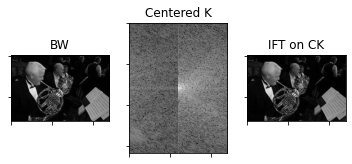

In [234]:
plot([im_test, amp_test, im_rev], ["BW", "Centered K", "IFT on CK"], rep("gray", 3), ncols=3)

In [0]:
# given fn2attr dict, indexes into array of kspace slices
class KSliceTfm(Transform):
  def setups(self, fn2attr, is_valid=False):
    self.fn2attr, self.is_valid = fn2attr, is_valid
    self.files, self.attrs = list(self.fn2attr.keys()), list(self.fn2attr.values())
    self.n_slices = [attr["n_slices"] for attr in self.attrs]
    self.cumsum = np.cumsum(n_slices)

  def encodes(self, i):
    fn2attr_idx  = np.searchsorted(self.cumsum, i)
    slice_idx = i - self.cumsum[fn2attr_idx]

    fname = self.files[fn2attr_idx]

    with h5py.File(fname, 'r') as data:
      kslice = data['kspace'][slice_idx]

    return kslice

## test

In [0]:
kslices = KSliceTfm()
kslices.setup(fn2attr)

In [256]:
x = kslices(47)
x.shape, type(x)

((640, 372), numpy.ndarray)

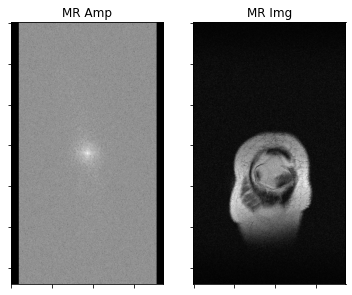

In [273]:
plot([k2amp(x), ks2im(x)], ["MR Amp", "MR Img"], ["gray_r", "gray"], ncols=2)

In [0]:
src = PROJ_PATH/"data"/ds # underlying source of data (URL, etc)

In [0]:
get_h5_files = FileGetter(suf="h5") # function to get items from path

In [0]:
items = get_image_files(path) # items are image files in folder
fn = items[0]; fn

Path('/root/.fastai/data/imagenette2-160/val/n03000684/n03000684_3532.JPEG')

# Data Transform (convert raw fn to k space)

In [0]:
# apparently scipy fft interleaves Real+Im of single px as 2 adj vals 
# https://stackoverflow.com/questions/38476359/fft-on-image-with-python/38507628
import scipy.fft as fp

In [0]:
# debug funcs
def arr_info(arr): print(arr.shape, type(arr))


In [0]:
pipe_fn2im = Pipeline([PILImageBW.create])
pipe_fn2k = Pipeline([PILImageBW.create, np.array, fp.rfft2, np.fft.fftshift])
pipe_k2fn = Pipeline([np.fft.ifftshift, fp.irfft])
pipe_k2amp = Pipeline([np.log, np.abs])

In [0]:
img = pipe_fn2im(fn)
kspace = pipe_fn2k(fn)
k_amp_img = pipe_k2amp(kspace)

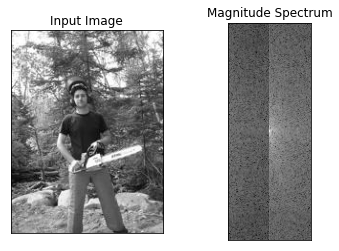

In [0]:
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(k_amp_img, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

Text(0.5, 1.0, 'Fourier transform')

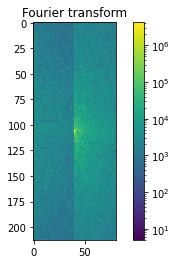

In [0]:
def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm(vmin=5))
    plt.colorbar()

plt.figure()
plot_spectrum(fshift)
plt.title('Fourier transform')

In [0]:
img_back = fp.irfft2(np.fft.ifftshift(fshift))
arr_info(img_back)


(213, 160) <class 'numpy.ndarray'>


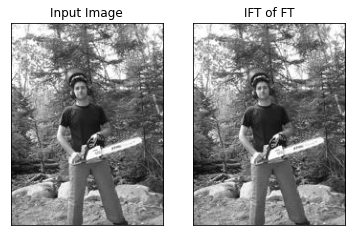

In [0]:
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('IFT of FT'), plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
??T.fft2

In [0]:
pipe = Pipeline([PILImage.create,tconv])

In [0]:
class KTfm(Transform):
    def __init__(self, vocab, o2i, lblr): self.vocab,self.o2i,self.lblr = vocab,o2i,lblr
    def encodes(self, o): return [resized_image(o), self.o2i[self.lblr(o)]]
    def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

## Convert imagenet to kspace in polar coord

In [0]:
def get_data(url, presize, resize):
  